<a href="https://colab.research.google.com/github/jensullrich/DataScienceSS20/blob/Project/Project_NLP_disaster_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup


## 1.1 Installation

In [1]:
!pip install tensorflow
!pip install --upgrade tensorflow-hub
!pip install bert-for-tf2
!pip install sentencepiece

Requirement already up-to-date: tensorflow-hub in /usr/local/lib/python3.6/dist-packages (0.8.0)
     |████████████████████████████████| 40kB 1.8MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.4-cp36-none-any.whl size=30114 sha256=45469c71f07c78c800986c66ce5dd8ebff5a1f074a0f566722d5ea4abe4c5c27
  Stored in directory: /root/.cache/pip/wheels/cf/3f/4d/79d7735015a5f523648df90d871ce8e89a7df8185f7703eeab
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7302 sha256=50a4783dba82220dd4192980d22afac49dab6607b2fdf34156329b2f0cf1d7f5
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19473 sha256=481d016d6ba54a4c9d61d1acafd789d5f2bc5eb38e805b58890a4ca4a9c37f5a
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params param

## 1.2 Imports

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
import bert
from sklearn.preprocessing import LabelEncoder

## 1.3 Cloud

In [3]:
#check if notebook runs in colab
IN_COLAB = 'google.colab' in sys.modules
print('running in Colab:',IN_COLAB)
path='..'
if IN_COLAB:
  #in colab, we need to clone the data from the repo
  !git clone -b Project https://github.com/jensullrich/DataScienceSS20/
  path='DataScienceSS20/Project'

running in Colab: True
Cloning into 'DataScienceSS20'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 743 (delta 19), reused 12 (delta 2), pack-reused 705
Receiving objects: 100% (743/743), 133.40 MiB | 13.24 MiB/s, done.
Resolving deltas: 100% (334/334), done.
Checking out files: 100% (223/223), done.


In [4]:
#check out the GPU
!nvidia-smi

Sat Jun 27 23:44:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
#TODO REMOVE
!pip install gputil

import GPUtil as GPU

GPUs = GPU.getGPUs()
gpu = GPUs[0]

def print_GPU_memory():
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

print_GPU_memory()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=1038ee6e9c5375d692502b2d70558f93c832ec470999834d2324cd7ed03b9fce
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


# 2. Exploring Data

In [6]:
# read the given csv files
train=pd.read_csv(path + '/DATA/train.csv', index_col='id')
test=pd.read_csv(path + '/DATA/test.csv', index_col='id')
submission = pd.read_csv(path + '/DATA/sample_submission.csv')

In [7]:
train.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## 2.1 NaN Values

Laut Beschreibung können sowohl keyword, als auch location fehlen. Es wird also zunächst untersucht wie viele Werte fehlen.

In [8]:
training_has_keyword = train["keyword"].notna().value_counts(normalize=True)
training_has_location = train["location"].notna().value_counts(normalize=True)
test_has_keyword = test["keyword"].notna().value_counts(normalize=True)
test_has_location = test["location"].notna().value_counts(normalize=True)

try:
    print(f'{training_has_keyword[True]*100:.1f}', "% of training data have keyword,", f'{(training_has_keyword[False])*100:.1f}', "% of keywords are missing")
    print(f'{training_has_location[True]*100:.1f}', "% of training data have location,", f'{(training_has_location[False])*100:.1f}', "% of locations are missing")
    print(f'{test_has_keyword[True]*100:.1f}', "% of test data have keyword,", f'{(test_has_keyword[False])*100:.1f}', "% of keywords are missing")
    print(f'{test_has_location[True]*100:.1f}', "% of test data have location,", f'{(test_has_location[False])*100:.1f}', "% of locations are missing")
except KeyError:
    print("No NaN values or they have already been replaced")

99.2 % of training data have keyword, 0.8 % of keywords are missing
66.7 % of training data have location, 33.3 % of locations are missing
99.2 % of test data have keyword, 0.8 % of keywords are missing
66.1 % of test data have location, 33.9 % of locations are missing


Die fehlenden Werte bekommen die aussagekräftigeren Einträge 'missing_keyword' bzw. 'missing_location'.

In [9]:
print("Replacing NaN values with missing_keyword and missing_location")
train["keyword"] = train["keyword"].fillna('missing_keyword')
train["location"] = train["location"].fillna('missing_location')
test["keyword"] = test["keyword"].fillna('missing_keyword')
test["location"] = test["location"].fillna('missing_location')

Replacing NaN values with missing_keyword and missing_location


## 2.2 Duplicate Values

In [10]:
duplicates = train[train.duplicated()]
# remove complete duplicates, keep only the first occurence
train.drop_duplicates(keep='first', inplace=True)
# check other duplicates
train.drop_duplicates('text', keep='False', inplace=True)
duplicates = train[train.duplicated(['text'], keep=False)]
duplicates.shape


(0, 4)

## 2.3 Exploration of keyword and location

In [11]:
print("We have", len(train["keyword"]), "tweets with", train["keyword"].nunique(), "unique keywords.")
print("We have", len(train["location"]), "tweets with", train["location"].nunique(), "unique locations.")

We have 7503 tweets with 222 unique keywords.
We have 7503 tweets with 3328 unique locations.


In [12]:
grouped = train.groupby(train["keyword"])
grouped.size().sort_values()

grouped = train.groupby(train["location"])
grouped.target.sum().sort_values(ascending=False).head(10)

location
missing_location    1044
USA                   67
United States         27
Mumbai                18
India                 17
Nigeria               17
London                16
New York              16
UK                    15
Washington, DC        15
Name: target, dtype: int64

## 2.4 Meta Features

In [13]:
# word_count
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))
test['word_count'] = test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
train['unique_word_count'] = train['text'].apply(lambda x: len(set(str(x).split())))
test['unique_word_count'] = test['text'].apply(lambda x: len(set(str(x).split())))

# url_count
train['url_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test['url_count'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
train['mean_word_length'] = train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test['mean_word_length'] = test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train['char_count'] = train['text'].apply(lambda x: len(str(x)))
test['char_count'] = test['text'].apply(lambda x: len(str(x)))

# hashtag_count
train['hashtag_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test['hashtag_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
train['mention_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
test['mention_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

# keyword target mean
train['keyword_target_mean'] = train.groupby('keyword')['target'].transform('mean')
test['keyword_target_mean'] = test['keyword'].apply(lambda x: train.loc[train['keyword'] == x, 'keyword_target_mean'].iloc[0])

In [14]:
train.sort_values(by='keyword_target_mean', ascending=False).head(10)
#test.sort_values(by='keyword_target_mean', ascending=False).head(10)

,keyword,location,text,target,word_count,unique_word_count,url_count,mean_word_length,char_count,hashtag_count,mention_count,keyword_target_mean
id,,,,,,,,,,,,
3537,derailment,"Chicago, IL",PHOTOS: Green Line derailment near Cottage Gro...,1,11,11,2,8.909091,108,0,0,1.0
3544,derailment,missing_location,Very sad to learn of the derailment of 2 train...,1,25,21,0,4.600000,139,0,1,1.0
3140,debris,"Tampa, FL",Debris confirmed from MH370; relatives hope fo...,1,17,17,1,7.058824,136,0,0,1.0
3141,debris,World news,ABC OnlineMH370: Aircraft debris found on La R...,1,21,20,0,5.523810,136,0,0,1.0
3142,debris,Hong Kong,Malaysia confirms Reunion Island debris is fro...,1,11,11,2,9.090909,110,0,1,1.0
3144,debris,missing_location,Debris confirmed from MH370; relatives hope fo...,1,15,15,1,6.666667,114,1,1,1.0
3145,debris,Hong Kong,Plane debris is from missing MH370 http://t.co...,1,7,7,1,7.285714,57,0,0,1.0
3147,debris,missing_location,MH370: Aircraft debris found on La Reunion is ...,1,20,20,1,5.850000,136,2,0,1.0
3150,debris,"Bristol, UK",Interesting: MH370: Aircraft debris found on L...,1,20,19,1,5.850000,136,0,0,1.0


In [15]:
from sklearn.preprocessing import StandardScaler

#define and scale our added features
train_meta_input = StandardScaler().fit_transform(train.iloc[:, 4:])
test_meta_input = StandardScaler().fit_transform(test.iloc[:, 3:])

META_DIM = train_meta_input.shape[1]
print(META_DIM)

8


# 3. Build Model

In [16]:
def bert_encode(tweet_texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []

    for text in tweet_texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [17]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
    meta_input = Input(shape=(META_DIM,), dtype=tf.float32, name='meta_input')

    pool_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    x = tf.keras.layers.Dense(32,activation='relu')(pool_output)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = Concatenate()([x, meta_input])
    x = Dropout(0.2)(x)
    out = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids, meta_input], outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [18]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/2"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 22.9 s, sys: 4.93 s, total: 27.8 s
Wall time: 43.7 s


In [19]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
FullTokenizer=bert.bert_tokenization.FullTokenizer
tokenizer = FullTokenizer(vocab_file, do_lower_case)

In [20]:
train_input = bert_encode(train.text.values, tokenizer, max_len=160)
test_input = bert_encode(test.text.values, tokenizer, max_len=160)
train_labels = train.target.values

In [21]:
model = build_model(bert_layer, max_len=160)
model.summary()

checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

# 4. Training

In [22]:
train_history = model.fit(
    [train_input, train_meta_input], train_labels, 
    validation_split=0.2,
    epochs=4,
    callbacks=[checkpoint],
    batch_size=16
)

Epoch 1/4
376/376 [==============================] - 460s 1s/step - loss: 0.5287 - accuracy: 0.7576 - val_loss: 0.3984 - val_accuracy: 0.8328
Epoch 2/4
376/376 [==============================] - 384s 1s/step - loss: 0.3986 - accuracy: 0.8411 - val_loss: 0.4175 - val_accuracy: 0.8381
Epoch 3/4
376/376 [==============================] - 457s 1s/step - loss: 0.3217 - accuracy: 0.8772 - val_loss: 0.3879 - val_accuracy: 0.8374
Epoch 4/4
376/376 [==============================] - 384s 1s/step - loss: 0.2610 - accuracy: 0.9030 - val_loss: 0.4719 - val_accuracy: 0.8281


# 5. Post-Processing

In [26]:
model.load_weights('model.h5')
test_pred = model.predict([test_input, test_meta_input])
test['prediction'] = test_pred

In [40]:
print(test.shape)
uncertain = test[(test['prediction'] < 0.85)]
print(uncertain.shape)
uncertain = uncertain[(uncertain['prediction'] > 0.35)]
print(uncertain.shape)
uncertain.head(50)

(3263, 12)
(2380, 12)
(605, 12)


,keyword,location,text,word_count,unique_word_count,url_count,mean_word_length,char_count,hashtag_count,mention_count,keyword_target_mean,prediction
id,,,,,,,,,,,,
12,missing_keyword,missing_location,We're shaking...It's an earthquake,4,4,0,7.750000,34,0,0,0.660714,0.689150
88,ablaze,missing_location,#nowplaying Alfons - Ablaze 2015 on Puls Radio...,10,10,1,7.100000,80,2,0,0.371429,0.373366
90,ablaze,"121 N La Salle St, Suite 500",'Burning Rahm': Let's hope City Hall builds a ...,21,21,1,5.857143,143,0,1,0.371429,0.591103
111,accident,Bexhill,@Traffic_SouthE @roadpol_east Accident on A27 ...,14,14,0,6.142857,99,0,2,0.685714,0.754021
142,accident,Las Vegas,Please donate and spread the word! A training ...,17,16,1,6.529412,127,0,0,0.685714,0.417578
188,aftershock,"London, England",Brass and Copper in Cataclysm &amp; AfterShock...,8,8,1,8.125000,72,0,0,0.000000,0.399708
206,airplane%20accident,missing_location,A girl who died in an airplane accident fiftee...,11,11,0,4.272727,57,0,0,0.852941,0.741175
286,ambulance,World,2 held with heroin in ambulance http://t.co/d9...,8,8,2,8.750000,77,0,0,0.526316,0.734110
292,ambulance,"West Chester, PA",Why should a helicopter ambulance ride to tran...,18,16,2,6.666667,137,0,0,0.526316,0.427684


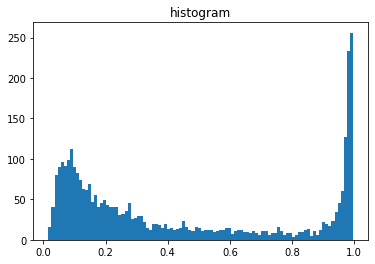

In [33]:
sorted = np.sort(test_pred, axis=0)

plt.hist(test_pred, bins = 100) 
plt.title("histogram") 
plt.show()


# 6. Final Results

In [ ]:
submission['target'] = test_pred.round().astype(int)
submission.to_csv('submission.csv', index=False)

In [36]:
from google.colab import drive
drive.mount('/content/drive')
root_path = '/content/drive/My Drive/INFM/DataScience/Project'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [38]:
model.save(root_path + '/models/model_2.h5') 